In [1]:
import numpy as np
import pandas as pd
import random
def sigmoid(x):
     return 1.0/(1.0+np.exp(-x))
def sigmoid_prime(x):
    return sigmoid(x)*(1-sigmoid(x))
class Network(object):
    
    def __init__(self,sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) 
                        for x, y in zip(sizes[:-1], sizes[1:])]
    
    def feedfoward(self,a):
        for b,w in zip(self.biases,self.weights):
            a=sigmoid(np.dot(w,a)+b)
        return a
    
    def stochasitc(self,train_data,epoches,mini_batch_size,lr,eva_data=None):
        if eva_data:
            test_num=len(eva_data)
        n=len(train_data)
        acc=[]
        for i in range(epoches):
            random.shuffle(train_data)
            mini_batches=[train_data[k:k+mini_batch_size]
                          for k in range(0,n,mini_batch_size)]
            for each_batch in mini_batches:
                self.updateGD(each_batch,lr)
            if eva_data:
                print ("Epoch {0}: {1} / {2}".format(
                    i, self.evaluate(eva_data), test_num))
            else:
                print ("Epoch {0} complete".format(i))
            
    def updateGD(self,batch,lr):
        '''update w and b by using GD method'''
        delta_w=[np.zeros(w.shape)for w in self.weights]
        delta_b=[np.zeros(b.shape)for b in self.biases]
        for x,y in batch:
            change_w,change_b=self.bp_my(x,y)
            delta_b=[nb+dnb for nb, dnb in zip(delta_b, change_b)]
            delta_w=[nw+dnw for nw, dnw in zip(delta_w, change_w)]
        self.weights=[w-(lr/len(batch))*nw for w,nw in zip(self.weights,delta_w)]
        self.biases=[b-(lr/len(batch))*nb for b, nb in zip(self.biases,delta_b)]
    
    def bp_my(self,x,y):
        '''cal the GD of loss function, x y are train data in batch'''
        GD_b=[np.zeros(b.shape)for b in self.biases]
        GD_w=[np.zeros(w.shape)for w in self.weights]
        activation=x
        activations=[x]
        net=[]#linear combination for each layer output
        for b,w in zip(self.biases,self.weights):
            z=np.dot(w,activation)+b
            net.append(z)
            activation=sigmoid(z)
            activations.append(activation)
        #backward
        delta=self.derivative_Cx(activations[-1],y)* sigmoid_prime(net[-1])
        GD_b[-1]=delta
        GD_w[-1]=np.dot(delta,activations[-2].transpose())
        for l in range(2,self.num_layers):
            de_sigmoid=sigmoid_prime(net[-l])
            delta=np.dot(self.weights[-l+1].transpose(),delta)*de_sigmoid
            GD_b[-l]=delta
            GD_w[-l]=np.dot(delta,activations[-l-1].transpose())
        return (GD_w,GD_b)
    
    def derivative_Cx(self,output,y):
        return (output-y)
    
    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedfoward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)
    

In [2]:
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import _pickle as cPickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('./data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data1, validation_data, test_data = \
load_data_wrapper()

In [4]:
my_net=Network([784,30,10])

In [5]:
#load predict data
test=pd.read_csv("./data./test_data.csv",header=None)
test=np.array(test)
test_nor=[]
#avoid overflow
for i in range(len(test)):
    sample=[]
    for j in range(len(test[0])):
        sample.append([test[i][j]/256.0])
    test_nor.append(sample)
test_nor=np.array(test_nor).astype(float)

In [6]:
my_net.stochasitc(training_data1, 15, 10, 3.0,eva_data=validation_data)

Epoch 0: 9166 / 10000
Epoch 1: 9283 / 10000
Epoch 2: 9350 / 10000
Epoch 3: 9440 / 10000
Epoch 4: 9445 / 10000
Epoch 5: 9468 / 10000
Epoch 6: 9493 / 10000
Epoch 7: 9487 / 10000
Epoch 8: 9513 / 10000
Epoch 9: 9488 / 10000
Epoch 10: 9498 / 10000
Epoch 11: 9534 / 10000
Epoch 12: 9517 / 10000
Epoch 13: 9514 / 10000
Epoch 14: 9522 / 10000


In [7]:
res=[]
for i in range(len(test_nor)):
    res.append(np.argmax(my_net.feedfoward(test_nor[i])))
len(res)

10000

In [8]:
def tocsv(outputs):
    test=pd.DataFrame(data=outputs)
    test.to_csv('./test_target.csv',index=False,header=None) 

In [9]:
tocsv(res)

Text(0, 0.5, 'acc')

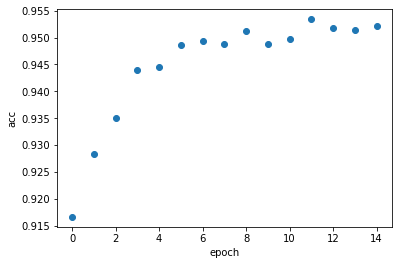

In [10]:
acc=[0.9166,0.9283,0.9350,0.9440,0.9445,0.9486,0.9493,0.9487,0.9513,0.9488,0.9498,0.9534,0.9517,0.9514,0.9522]
import matplotlib.pyplot as plt
plt.scatter(range(len(acc)),acc)
plt.xlabel("epoch")
plt.ylabel("acc")